## Modèle en production

Laurent Cetinsoy - Datadidacte

Une des supposition centrale pour qu'un modèle de machine learning marche est que la distribution des données ne diffère pas de celle des données d'entrainement.

On ne peut garantir la généralisation d'un modèle que si la distribution des données est similaire à celle de la distribution $ X_{prod} \tilde{} \,  P_{train}$

Ainsi, si les données que le modèle voient en production n'ont pas la même distribution (ne ressemblent pas) aux données de train, alors le modèle aura peu de chance de faire de bonne prédictions.

Il est donc important de surveille les données vues par le modèle en production.

Pour cela on va mesurer ce qu'on appelle le Data drift : on va mesurer à quel point les données s'écartent des données de train.

Et on pourra ainsi lever une alerte si c'est le cas.

## Utilisation Eurybia



En consultant la documentation de Eurybia (https://eurybia.readthedocs.io/en/latest/overview.html), expliquer le principe de fonctionnement de Euribya :

- A quoi sert le modèle de classification ?
- A-t-on besoin d’avoir les labels issus de la production pour pouvoir utiliser cette approche ?
- Quel est le critère pour déterminer qu’il y a un data-drift ?


In [1]:
"""
Le modèle de classification permet de déterminer si les données de production sont similaires aux données d'entrainement.

On n'a pas besoin des labels issus de la production pour utiliser cette approche.

Le critère pour déterminer qu'il y a un data-drift est la probabilité de rejet. Si la probabilité de rejet est supérieure à un seuil, alors on considère qu'il y a un data-drift.
"""

"\nLe modèle de classification permet de déterminer si les données de production sont similaires aux données d'entrainement.\n\nOn n'a pas besoin des labels issus de la production pour utiliser cette approche.\n\nLe critère pour déterminer qu'il y a un data-drift est la probabilité de rejet. Si la probabilité de rejet est supérieure à un seuil, alors on considère qu'il y a un data-drift.\n"

Installer eurybia

In [2]:
!pip install eurybia

In [3]:
import eurybia
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [4]:
!ls

datadrift_auc.csv  houses.csv  report_drift.html  report_messed_up.html  resnet32.h5  sample_data


In [5]:
df = pd.read_csv('houses.csv')

Utiliser eurybia pour monitorer le modèle. Dans un premier temps faire en sorte que les données (df_current) soient de la même distribution que vos données d’entraînement. Vérifier que Eurybia pense que le modèle ne drift pas


In [6]:
df_train, df_prod = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
sd = eurybia.SmartDrift(
  df_current=df_prod,
  df_baseline=df_train,
  dataset_names={"df_current": "Current dataset Name", "df_baseline": "Baseline dataset Name"}
  )

In [8]:
sd.compile(
  full_validation=False, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
  datadrift_file="datadrift_auc.csv", # Optional: name of the csv file that contains the performance history of data drift
  )

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7fb5fc08d690>
The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.5


In [9]:
sd.generate_report(
  output_file='report_drift.html',
  title_story="my_report_title",
  )

/usr/local/lib/python3.10/dist-packages/eurybia/report/generation.py:17: UserWarning:

Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.



Faire de même avec des données de test. Les données de tests ont-elle un drift par rapport au train ?


In [10]:
# PASS

Générer des données qui ne ressemblent ni au train ni au test (par exemple avec des données abérentes). Euribya détecte-t-il ces données ?

In [11]:
df_train, df_prod = train_test_split(df, test_size=0.2, random_state=42)

df_train['garden'] /= 4
df_train['price'] *= 12
df_train['nb_rooms'] += 2

In [12]:
sd = eurybia.SmartDrift(
  df_current=df_prod,
  df_baseline=df_train,
  dataset_names={"df_current": "Current dataset Name", "df_baseline": "Baseline dataset Name"}
  )

sd.compile(
  full_validation=False, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
  datadrift_file="datadrift_auc.csv", # Optional: name of the csv file that contains the performance history of data drift
  )

sd.generate_report(
  output_file='report_messed_up.html',
  title_story="my_report_title",
  )

The following variables have mismatching dtypes
             and will not be analyzed: 
 ['garden']
INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7fb5f8cbe2c0>
The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.9375


## Alibaba detect

Dans cette partie on va utiliser la librairie https://github.com/SeldonIO/alibi-detect pour faire la détection de problèmes
Installer la librairie avec pip

In [13]:
!pip install alibi-detect[tensorflow]

Charger le jeu de donnée cifar10 avec keras et récupérer le train et le test puis,

Normaliser les données de train en faisant un MinMaxScaling (diviser par 255)

In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [15]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

Dans le sous package alibbi_detect.datasets importer les  fonction fetch_cifar10c et corruption_types_cifar10c

In [16]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

Afficher les types de corruption de données disponible avec la fonction corruption_types_cifar10c

In [17]:
corruption_types_cifar10c()

['brightness',
 'contrast',
 'defocus_blur',
 'elastic_transform',
 'fog',
 'frost',
 'gaussian_blur',
 'gaussian_noise',
 'glass_blur',
 'impulse_noise',
 'jpeg_compression',
 'motion_blur',
 'pixelate',
 'saturate',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'zoom_blur']

Avec la fonction fetch_cifar10c récupérer des exemples corrompus de donnée ressemblant à cifar 10 et les stocker dans des variable X_corrupted et y_corrupted.

Vous choisirez au moins les corruptions suivantes : ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']

Vous spécifirez les argument severity=5 et return_X_y=True

In [18]:
for corruption in ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']:
  X_corrupted, y_corrupted = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)

Normaliser les images corrompues

In [19]:
X_corrupted = X_corrupted / 255.0

Afficher plusieurs des images corrompues.

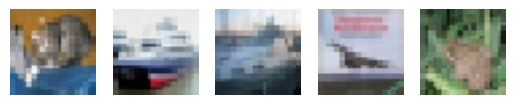

In [20]:
import matplotlib.pyplot as plt

for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_corrupted[i])
  plt.axis('off')
plt.show()

On va maintenant prendre un modèle entraîné sur cifar10 pour voir l'impact des performances sur le modèle.

Avec la fonction  fetch_tf_model du module alibi_detect.utils.fetching, charger le modèle préentraîné resnet32 sur cifar10


In [21]:
import tensorflow as tf
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector

dataset = 'cifar10'
model_name = 'resnet32'
model = fetch_tf_model(dataset, model_name)

Calculer la performance du model sur le jeu de train et de test

In [22]:
model.evaluate(x_train, y_train)

1563/1563 [==============================] - 195s 124ms/step - loss: 1.9381 - sparse_categorical_accuracy: 0.6163


[1.9380967617034912, 0.6162999868392944]

In [23]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 38s 122ms/step - loss: 2.0559 - sparse_categorical_accuracy: 0.6042


[2.0559356212615967, 0.604200005531311]

Calculer la performance du modèle sur le jeu de donnée corrompu. Vous devriez observer qu'il chute significativement

In [24]:
model.evaluate(X_corrupted, y_corrupted)

313/313 [==============================] - 40s 124ms/step - loss: 9.1293 - sparse_categorical_accuracy: 0.1329


[9.129256248474121, 0.13289999961853027]

On va maintenant voir comment détecter les changement de distributions de données.

Pour les données non tabulaire ou à haute dimension on procéde généralement en deux étapes :

1. Faire une réduction de dimension
2. Faire un test permettant de voir si les données projetées ont changé de distribution ou pas

Il existe plusieurs manières de faire de la réduction de dimension. La plus classique est la PCA.

Il est possible également d'utiliser des Auto-encoder

Le code suivant permet de créer la première partie (l'encoder) d'un auto-encoder simple qui nous servira à réduire les dimension des données.

In [25]:
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

Le drift detector a besoin d'une donnée de référence afin d'effectuer la comparaison avec les données à monitorer.
Créer une variable X_ref avec un échantillon aléatoire des données de test

In [26]:
X_ref = x_test[np.random.choice(x_test.shape[0], 1000, replace=False)]

A quoi sert le test statistique kolmogorov smirnoff ?

In [27]:
"""
Le test statistique kolmogorov smirnoff est utilisé pour comparer deux distributions de données.
"""

'\nLe test statistique kolmogorov smirnoff est utilisé pour comparer deux distributions de données.\n'

Instancier la classe KSDrift dans une variable nommée **detector**

Il faut lui passer le dataset de reference, une p value (prendre 0.05) et une fonction permettant de faire le preprocessing. On a créé la fonction pour vous


In [28]:
from alibi_detect.cd.tensorflow import preprocess_drift
from functools import partial
from alibi_detect.cd import KSDrift
preprocess_function = partial(preprocess_drift, model=encoder_net, batch_size=32)

detector = KSDrift(X_ref, p_val=0.05, preprocess_fn=preprocess_function)

A laide du Drift detector et la méthode predict faire des prediction sur les données de test et sur les données corrompue pour voir si il détecte un changement de distribution

In [29]:
predictions = detector.predict(x_test)

print(predictions)

{'data': {'is_drift': 1, 'distance': array([0.0222, 0.0224, 0.0257, 0.0118, 0.0201, 0.0336, 0.028 , 0.0398,
       0.0288, 0.0337, 0.0197, 0.019 , 0.0266, 0.0245, 0.0641, 0.0234,
       0.0298, 0.026 , 0.0199, 0.0232, 0.0364, 0.0357, 0.0284, 0.0247,
       0.0249, 0.0218, 0.0379, 0.0327, 0.0469, 0.0259, 0.0329, 0.0205],
      dtype=float32), 'p_val': array([0.7527486 , 0.7429408 , 0.5765008 , 0.9994602 , 0.8488057 ,
       0.25065157, 0.46583548, 0.10930074, 0.42992344, 0.24760394,
       0.8651292 , 0.8917064 , 0.53208464, 0.63708544, 0.00108686,
       0.69295406, 0.38731   , 0.5615682 , 0.85706437, 0.7030483 ,
       0.17539844, 0.19230792, 0.44768634, 0.62692505, 0.61678153,
       0.7721017 , 0.14311884, 0.2793331 , 0.0355075 , 0.566533  ,
       0.2727633 , 0.8317434 ], dtype=float32), 'threshold': 0.0015625}, 'meta': {'name': 'KSDrift', 'online': False, 'data_type': None, 'version': '0.12.0', 'detector_type': 'drift'}}


In [30]:
predictions = detector.predict(X_corrupted)

print(predictions)

{'data': {'is_drift': 1, 'distance': array([0.0337, 0.0199, 0.0352, 0.0315, 0.0372, 0.0514, 0.0239, 0.0472,
       0.0376, 0.0485, 0.0221, 0.0377, 0.0335, 0.0378, 0.0519, 0.0217,
       0.0555, 0.0303, 0.0262, 0.0353, 0.0449, 0.0481, 0.0327, 0.0203,
       0.0172, 0.0308, 0.0324, 0.0373, 0.0712, 0.0296, 0.0389, 0.0362],
      dtype=float32), 'p_val': array([2.4760394e-01, 8.5706437e-01, 2.0514342e-01, 3.2113090e-01,
       1.5753216e-01, 1.5829578e-02, 6.6759866e-01, 3.3723135e-02,
       1.4916024e-01, 2.6868792e-02, 7.5762147e-01, 1.4712407e-01,
       2.5372687e-01, 1.4511032e-01, 1.4404748e-02, 7.7687836e-01,
       7.1100439e-03, 3.6700892e-01, 5.5167985e-01, 2.0252487e-01,
       4.9654361e-02, 2.8833428e-02, 2.7933311e-01, 8.4036231e-01,
       9.4651991e-01, 3.4740046e-01, 2.8939953e-01, 1.5540478e-01,
       1.8805370e-04, 3.9562112e-01, 1.2439391e-01, 1.8010578e-01],
      dtype=float32), 'threshold': 0.0015625}, 'meta': {'name': 'KSDrift', 'online': False, 'data_type': None,